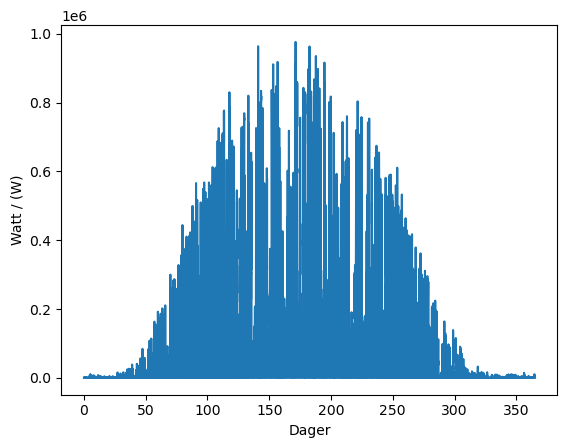

In [34]:
from suncalc import get_position, get_times
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
import os

utc = []

# definerer arealvektoren
A = np.array([308.0,1148.9,-7248.3])

# koordinater til skolen
lon = 5.338874
lat = 60.385389

# leser inn datasettet, 9999.99 er målefeil
#df = pd.read_csv('2022.csv')
df = pd.read_csv('2022.csv',na_values = 9999.99)

def vinkel(az,al,arealvektor):
    retningsvektor = np.array([np.cos(az),np.sin(az),np.tan(al)])
    a = np.arccos(retningsvektor@arealvektor/np.linalg.norm(arealvektor)/np.linalg.norm(retningsvektor))
    return a
               
# tilpasser tidsangivning til riktig format
df['Dato'] = df['Dato'].str.ljust(11) 
df['Dato'] = df['Dato'] + df['Tid']
df = df.drop('Tid', axis=1)

# skifter tiden til UTC-tidssonen
for i in range(len(df['Dato'])):
    local_time = df['Dato'][i]
    local_tz = pytz.timezone('Europe/Oslo')
    utc_tz = pytz.utc
               
    local_dt = datetime.strptime(local_time, '%Y-%m-%d %H:%M')
    local_dt = local_tz.localize(local_dt)
    utc_dt = local_dt.astimezone(utc_tz)
    utc.append(str(utc_dt)[:16])
          
# lager en kopi for å jobbe med
df1 = df.copy()
df1['Dato'] = utc

# lager et dictionary med vinkler
Lon = np.ones(len(df1['Dato']))*lon
Lat = np.ones(len(df1['Dato']))*lat
dict = get_position(df1['Dato'], Lon, lat) 

# omdanner til DataFrame og legger sammen med df1
dict_df = pd.DataFrame(dict)
df1 = pd.concat([df1, dict_df], axis=1)


# Fjerner alle rader der Globalstråling er mindre enn 0
df1.drop(df1[df1['Globalstraling'] < 0.1].index, inplace=True)

# Endrer vinkelverdiene siden de er oppgitt på en merkelig måte
df1['azimuth'] = df1['azimuth']* -1 + np.pi/2


# Regner energi for hver periode
indeks_liste = list(df1.index.values)
energi = []
for i in indeks_liste:
    az = df1['azimuth'][i]
    al = df1['altitude'][i]
    vinkel_sol = vinkel(az,al,A)
    
    # legger data inn i en liste
    energi.append(np.cos(vinkel_sol) * df1['Globalstraling'][i] * np.linalg.norm(A))

    
# legger inn panel effektivitet og sjekker for NaN-verdier
energi = np.array(energi)
energi = energi*0.21
energi = energi[np.isfinite(energi)]

# Plotter resultatene
tid = np.linspace(0,365,len(energi))
plt.plot(tid,abs(energi))
plt.xlabel('Dager')
plt.ylabel('Watt / (W)');

skalarproduktet er negativt fordi vektorene peker motsatt vei

In [20]:
total = sum(abs(energi))
total = total/(6*1000)
print(f'Totalen blir {round(total,2)} kWh')

Totalen blir 507252.95 kWh


Ifølge forbrukerguiden (https://forbrukerguiden.no/normalt-stromforbruk/#:~:text=Normalt%20str%C3%B8mforbruk%20varierer%20med%20st%C3%B8rrelsen%2C%20men%20de%20fleste,vil%20ha%20et%20normalt%20str%C3%B8mforbruk%20p%C3%A5%20500%20kWh.) vil et vanlig strømforbruk for en leilighet på 100 m^2 være på rundt 500 kWh i måneden.

In [22]:
round(total/(500*12),2)

84.54

Dette er hvor mange leiligheter som vil kunne fungere bare på energi fra solcellepanelene, totalt sett. I realiteten vil panelene supplere mye mer effekt til leilighetene om sommeren enn om vinteren. Da må det suppleres med andre kilder om vinteren og spres til flere leiligheter om sommeren. Et vannkraftverk er et alternativ til en strømkilde som kunne fungert bra sammen med panelene.